# Decision Trees for Texas Weather Classification

This notebook implements Decision Tree algorithms to classify weather conditions in Texas, specifically focusing on identifying 'extremely hot' days versus 'normal' days. We'll explore both basic Decision Trees and Random Forests.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.inspection import permutation_importance

In [13]:
# Load the weather data
df = pd.read_csv("../../weather_data.csv")

# Define features for classification
features = [
    'max_temp',
    'min_temp',
    'humidity',
    'wind_speed',
    'precipitation',
    'pressure'
]

# Create target variable (1 for extremely hot days, 0 for normal days)
df['is_extreme'] = (df['max_temp'] >= 95).astype(int)

# Split features and target
X = df[features].values
y = df['is_extreme'].values

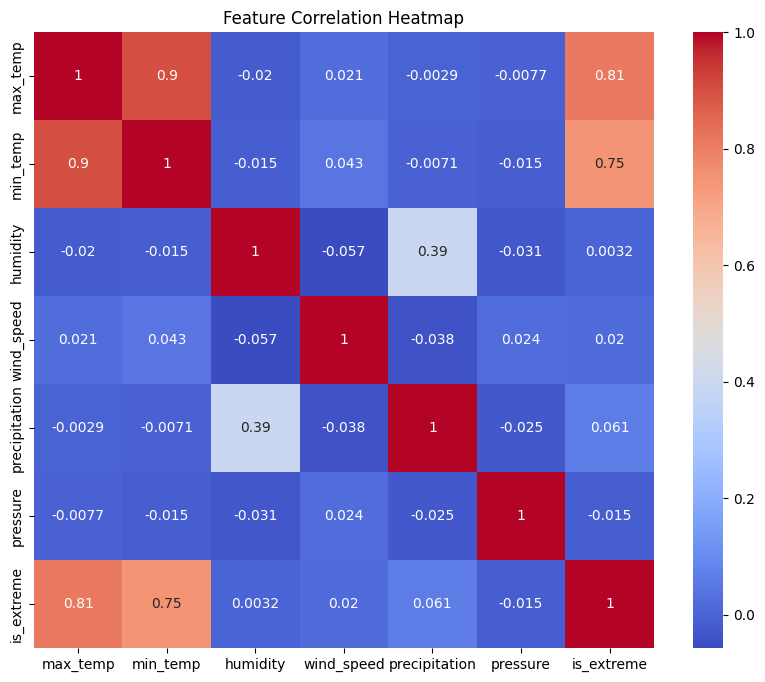

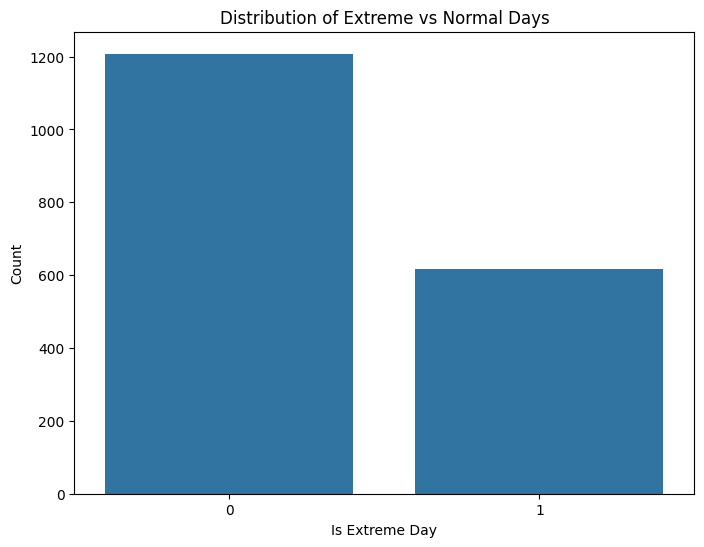

In [14]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features + ['is_extreme']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Plot distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='is_extreme')
plt.title('Distribution of Extreme vs Normal Days')
plt.xlabel('Is Extreme Day')
plt.ylabel('Count')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       120

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



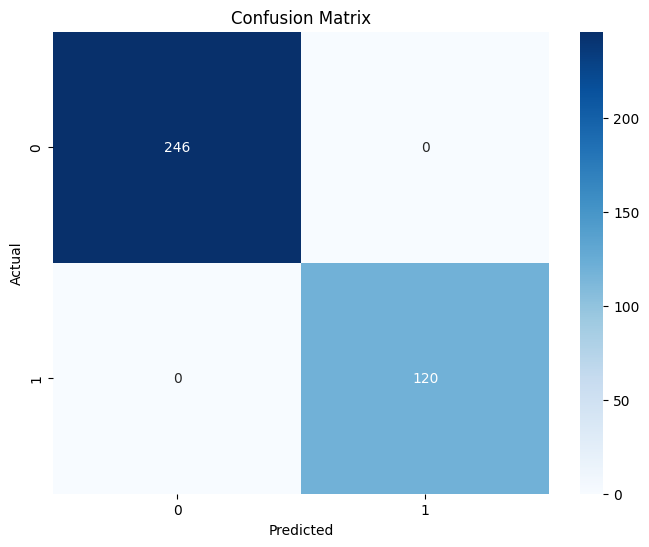

In [15]:
# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Decision Tree model
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)

# Make predictions
y_pred = dt.predict(X_test_scaled)

# Print classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

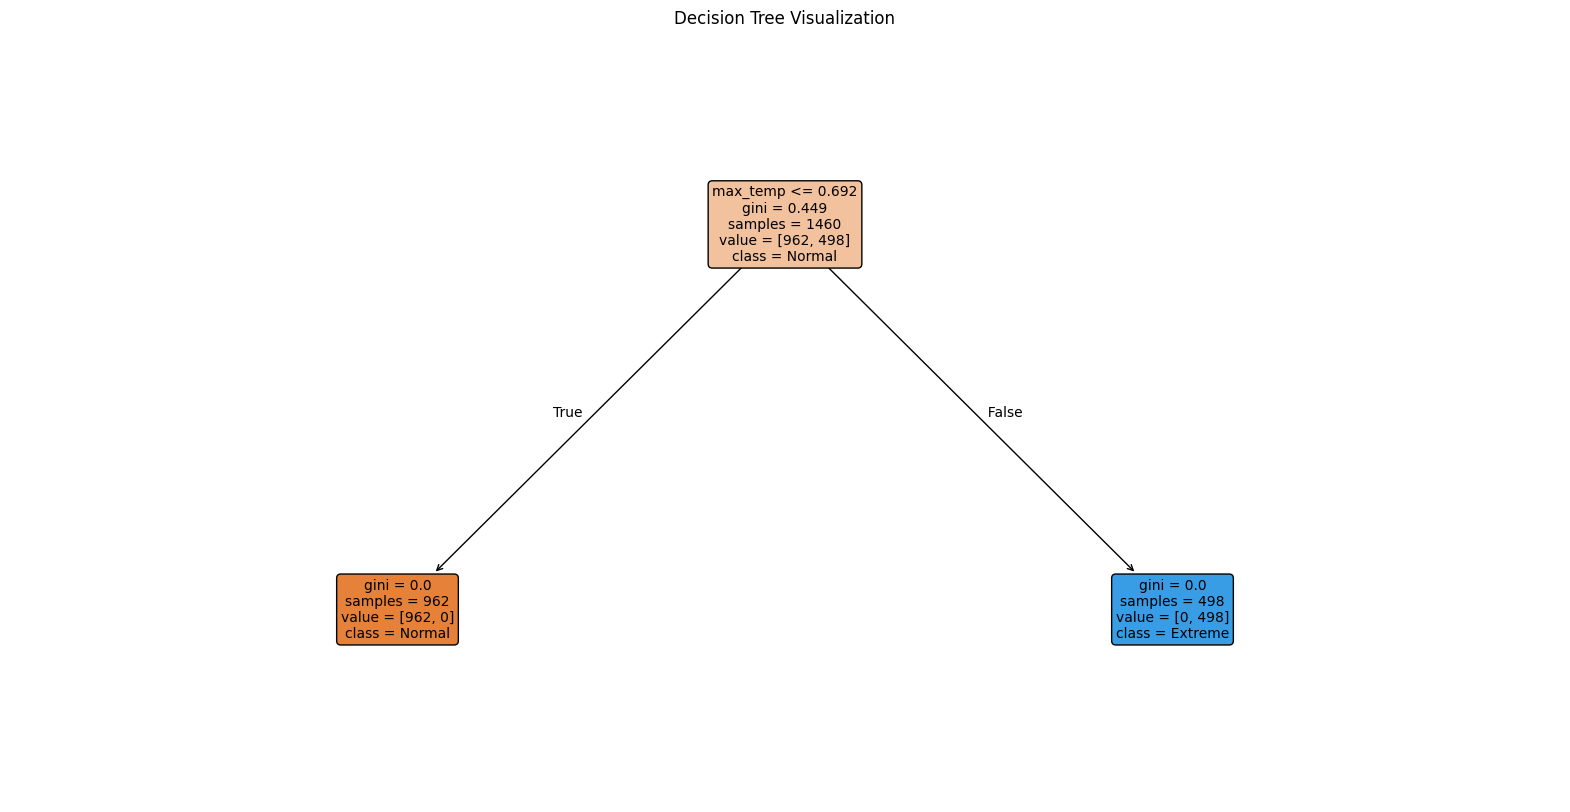

In [16]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=features, class_names=['Normal', 'Extreme'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       120

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



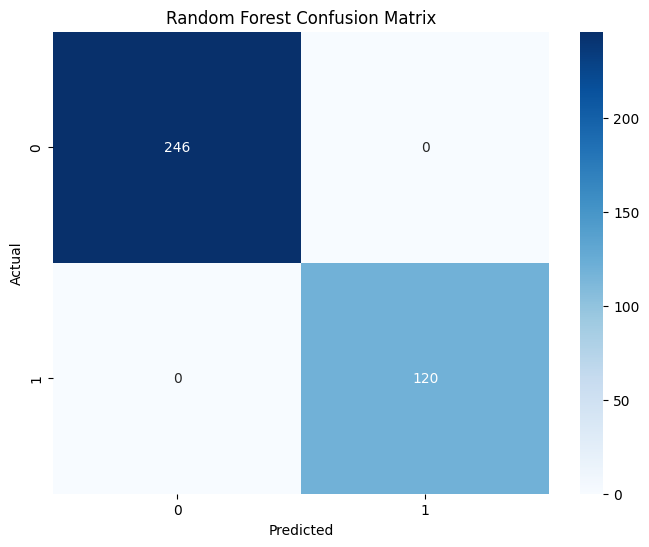

In [17]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_scaled)

# Print classification report
print(classification_report(y_test, y_pred_rf))

# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

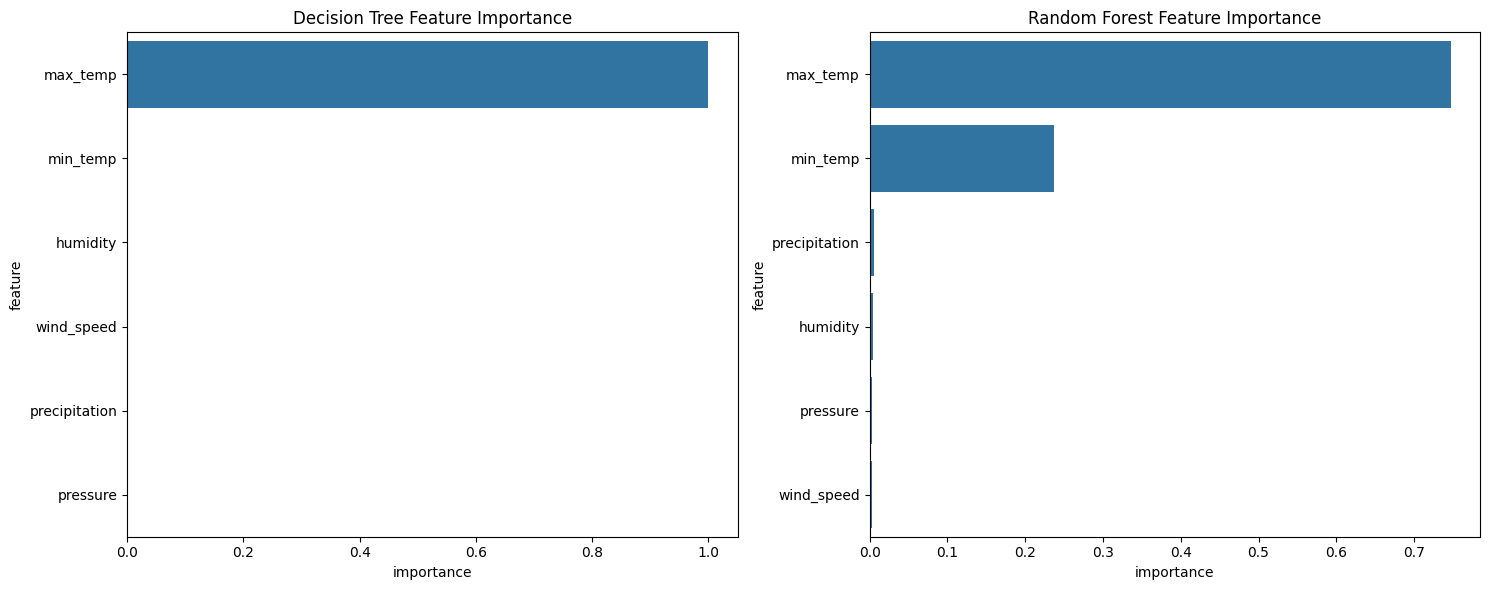


Decision Tree Feature Importance:
         feature  importance
0       max_temp         1.0
1       min_temp         0.0
2       humidity         0.0
3     wind_speed         0.0
4  precipitation         0.0
5       pressure         0.0

Random Forest Feature Importance:
         feature  importance
0       max_temp    0.747344
1       min_temp    0.236569
4  precipitation    0.005284
2       humidity    0.004644
5       pressure    0.003270
3     wind_speed    0.002888


In [18]:
# Calculate feature importance for both models
dt_importance = pd.DataFrame({
    'feature': features,
    'importance': dt.feature_importances_
})
dt_importance = dt_importance.sort_values('importance', ascending=False)

rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
})
rf_importance = rf_importance.sort_values('importance', ascending=False)

# Plot feature importance for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='importance', y='feature', data=dt_importance, ax=ax1)
ax1.set_title('Decision Tree Feature Importance')

sns.barplot(x='importance', y='feature', data=rf_importance, ax=ax2)
ax2.set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()

# Print feature importance values
print("\nDecision Tree Feature Importance:")
print(dt_importance)
print("\nRandom Forest Feature Importance:")
print(rf_importance)

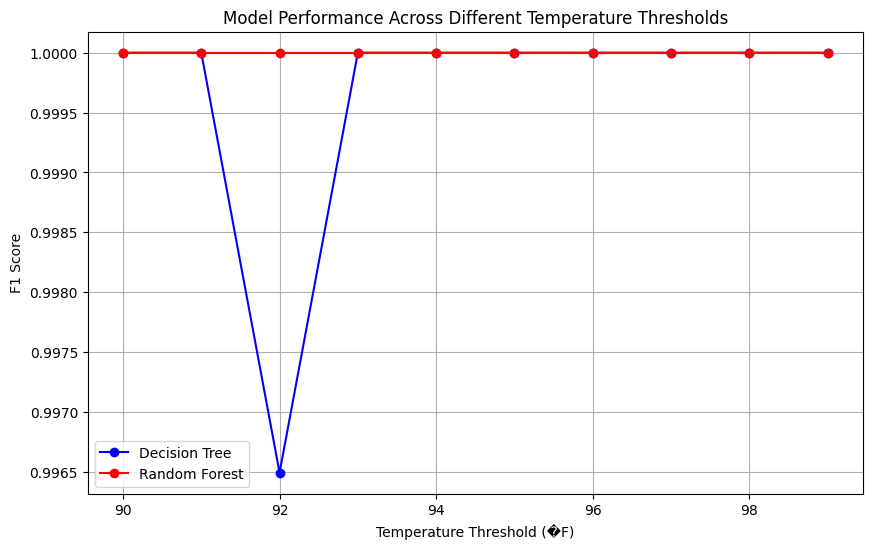

In [19]:
# Analyze model performance across different temperature thresholds
thresholds = range(90, 100, 1)
dt_scores = []
rf_scores = []

for threshold in thresholds:
    # Create new target variable with current threshold
    y_new = (df['max_temp'] >= threshold).astype(int)
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and evaluate Decision Tree
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_train_scaled, y_train)
    y_pred_dt = dt.predict(X_test_scaled)
    dt_scores.append(f1_score(y_test, y_pred_dt))
    
    # Train and evaluate Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    rf_scores.append(f1_score(y_test, y_pred_rf))

# Plot F1 scores for different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, dt_scores, 'bo-', label='Decision Tree')
plt.plot(thresholds, rf_scores, 'ro-', label='Random Forest')
plt.xlabel('Temperature Threshold (�F)')
plt.ylabel('F1 Score')
plt.title('Model Performance Across Different Temperature Thresholds')
plt.legend()
plt.grid(True)
plt.show()